In [35]:
import sisl
from sisl import *
import sisl.viz
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sisl.viz import merge_plots
from sisl.viz.processors.math import normalize
from functools import partial
# To quickly plot the hamiltonian matrix
import plotly.express as px
import cmath
import scipy
from scipy.linalg import ishermitian
from scipy.linalg import schur, eigvals
from matplotlib.colors import LogNorm
import cmocean


In [36]:
cell = sisl.Geometry(
    [[0, 0, 0], [1, 0, 0]],
    [Atom("C", maxR =1.43420), Atom("C", maxR = 1.43420)],
    lattice=Lattice([2.0, 10, 10], nsc=[3, 1, 1]) #, origin=[-5] * 3
)

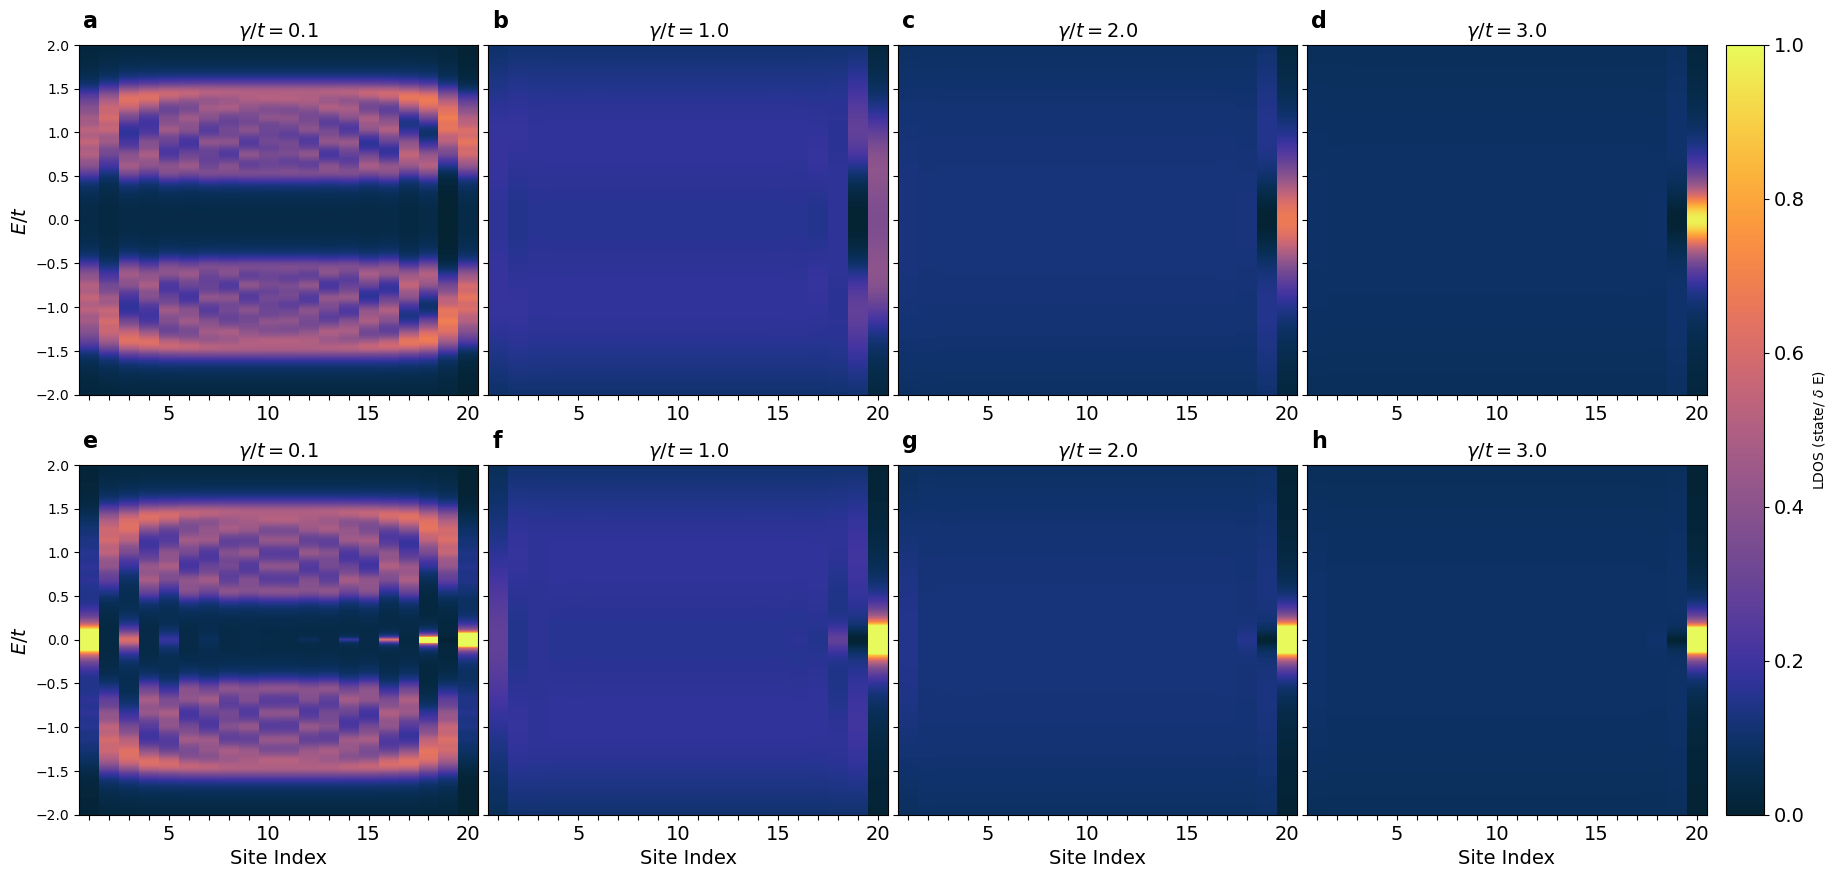

In [5]:
N = 10 
# Topologically trivial parameters
t1_triv = 1.0
t2_triv = 0.5
# Topologically non-trivial parameters
t1_nontriv = 0.5
t2_nontriv = 1.0

#gamma_values = [0.1*t1_triv, 1.0*t1_triv, 2.0*t1_triv]  # Three different gamma_1 values
gamma_values = [0.1, 1.0, 2.0, 3.0]  # Three different gamma_1 values

# Define a suitable energy range for LDOS calculation
energy_min = -2.0
energy_max = 2.0
num_energy_points = 1000
energyGrid = np.linspace(energy_min, energy_max, num_energy_points)

# Helper function to compute LDOS data for given t1, t2 and gamma values
def compute_ldos_for_params(t1, t2, gamma_vals, N, energyGrid):
    ldos_data = []
    for gamma in gamma_vals:
        #cell = sisl.UnitCell([1.0])  # minimal cell, placeholder
        # Build Hamiltonian
        H = sisl.Hamiltonian(cell, dtype='complex')
        # On-site terms
        H[0, 0] = -gamma*1j
        H[1, 1] = -gamma*1j
        # Hoppings
        H[0, 1] = t1 
        H[1, 0] = t1
        H[0, 1, (-1, 0)] = t2
        H[1, 0, (1, 0)] = t2
        H1 = H.tile(N,0)
        # Decoupling bit:
        for k in np.arange(19,2*N):
            H1[k,k] = 0
        H1.set_nsc([1,1,1])
        H2 = H1.Hk().toarray()
        LDOSperSite = np.zeros((2*N, len(energyGrid)))
        for i, E in enumerate(energyGrid):
            denom = E*np.eye(2*N, dtype=complex) - H2
            G_R = np.linalg.inv(denom)
            LDOSperSite[:, i] = -np.imag(np.diag(G_R))/np.pi
        ldos_data.append(LDOSperSite)
    return ldos_data

# Compute LDOS for the trivial case
ldos_trivial = compute_ldos_for_params(t1_triv, t2_triv, gamma_values, N, energyGrid)
# Compute LDOS for the non-trivial case
ldos_nontrivial = compute_ldos_for_params(t1_nontriv, t2_nontriv, gamma_values, N, energyGrid)

# Determine global max for colorbar scaling across all six subplots
all_data = ldos_trivial + ldos_nontrivial
global_max = max(np.max(data) for data in all_data)
vmin, vmax = 0, 1 #global_max*0.1

# Now plot
fig, axes = plt.subplots(2, 4, figsize=(25, 10), sharey=True)
fig.subplots_adjust(wspace=0.025, hspace=0.2)  # Adjust spacing

panel_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
X_sites, Y_energy = np.meshgrid(np.arange(2*N), energyGrid)

# Top row: Trivial case
for m, gamma in enumerate(gamma_values):
    LDOSperSite = ldos_trivial[m]
    ax = axes[0, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    #ax.set_xlabel('Site Index', fontsize=12)
    if m == 0:
        ax.set_ylabel('$E/t$', fontsize=14)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=14)
    ax.set_xticks(np.arange(2*N))            # from 0 to 19
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Edit thomas idea    
    custom_labels = [5, 10, 15, 20]  # Labels you want
    all_ticks = np.arange(2*N)  # Original tick positions
    custom_tick_labels = [label if label in custom_labels else "" for label in all_ticks + 1]
    ax.set_xticklabels(custom_tick_labels, fontsize=14)

    #ax.set_xticks(np.arange(0.5, 20.5, step=1) - 0.5)
#    ax.set_xticks(np.arange(2*N))            # from 0 to 19
#    ax.set_xticklabels(np.arange(1, 2*N+1))  # label from 1 to 20
    #odd_sites = np.arange(1, 2*N+1, 2)
    #odd_indices = odd_sites - 1
    #ax.set_xticks(odd_indices)
    #ax.set_xticklabels(odd_sites)
    ax.text(0.01, 1.10, panel_labels[m], transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left')
            

# Bottom row: Non-trivial case
for m, gamma in enumerate(gamma_values):
    LDOSperSite = ldos_nontrivial[m]
    ax = axes[1, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    ax.set_xlabel('Site Index', fontsize=14)
    if m == 0:
        ax.set_ylabel('$E/t$', fontsize=14)

    ax.set_title(r'$\gamma/ t= {:.1f}$'.format(gamma), fontsize=14)
    ax.set_xticks(np.arange(2*N))            # from 0 to 19
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Edit thomas idea    
    custom_labels = [5, 10, 15, 20]  # Labels you want
    all_ticks = np.arange(2*N)  # Original tick positions
    custom_tick_labels = [label if label in custom_labels else "" for label in all_ticks + 1]
    ax.set_xticklabels(custom_tick_labels, fontsize=14)

   # ax.set_xticklabels(np.arange(1, 2*N+1))  # label from 1 to 20
    #odd_sites = np.arange(1, 2*N+1, 2)
    #odd_indices = odd_sites - 1
    #ax.set_xticks(odd_indices)
    #ax.set_xticklabels(odd_sites)

    #ax.set_xticks(np.arange(0.5, 20.5, step=1) - 0.5)
    ax.text(0.01, 1.10, panel_labels[m+4], transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left')

# Add a single colorbar for all subplots
cbar = fig.colorbar(pcm, ax=axes.ravel().tolist(), label='LDOS (state/ $\delta$ E)', pad=0.01)
cbar.ax.tick_params(labelsize=14)

#plt.suptitle("M = 1")
plt.savefig('fig6Combo3.pdf', format='pdf', bbox_inches='tight')
plt.show()


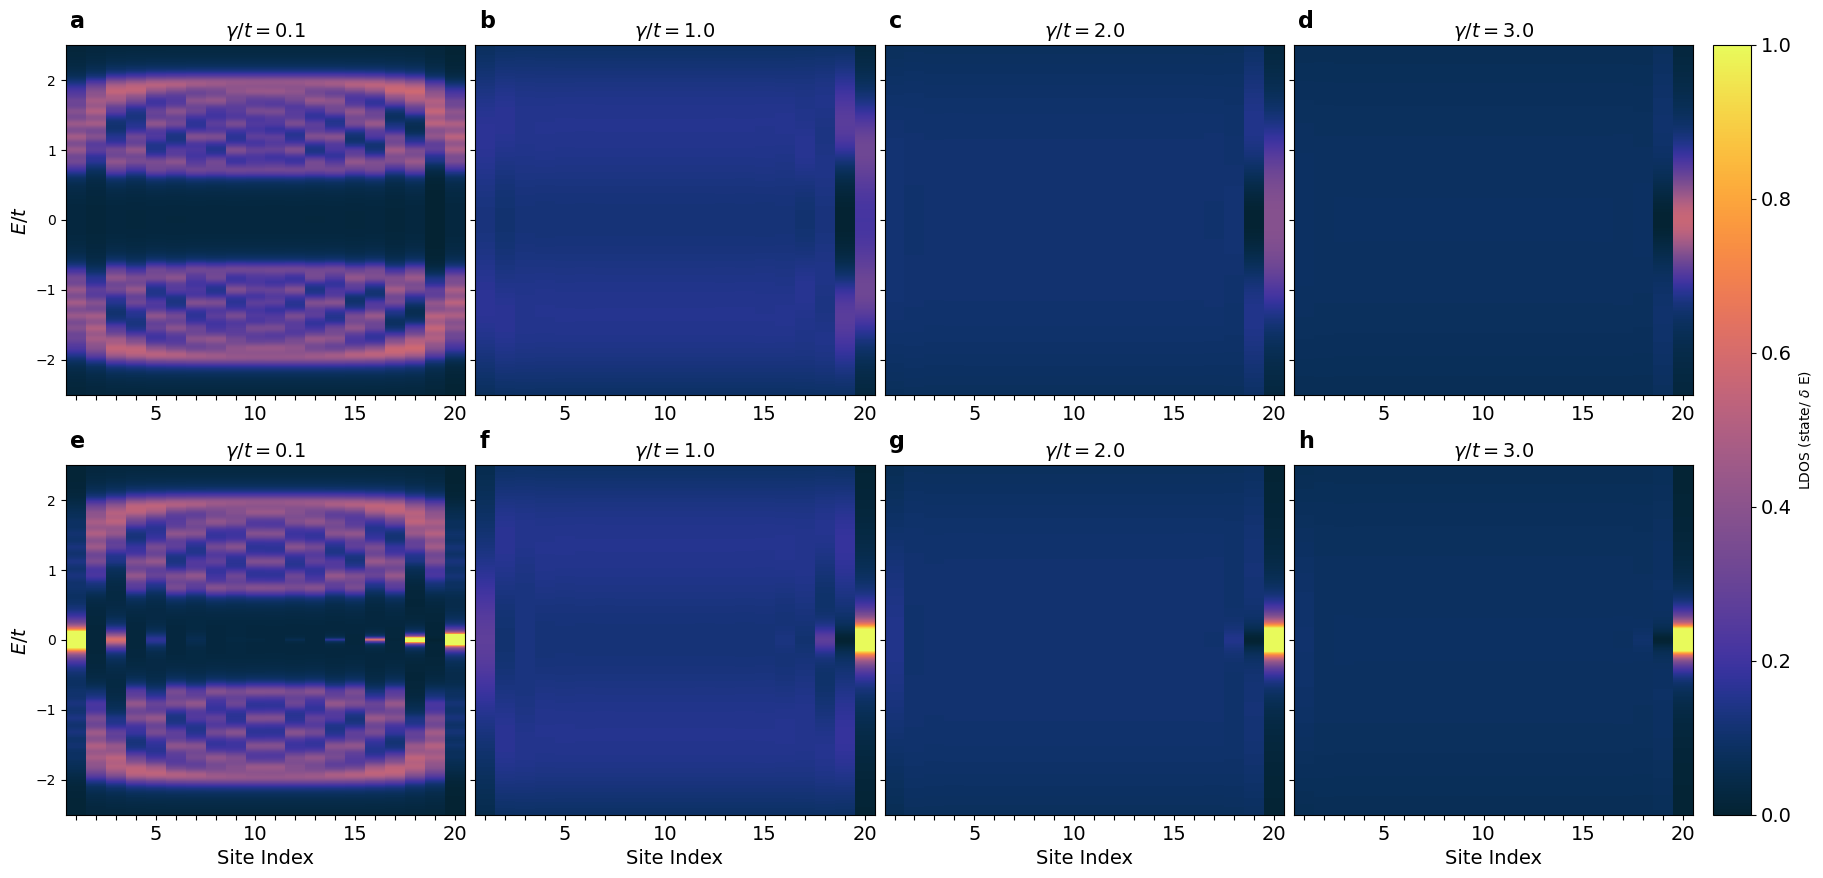

In [37]:
N = 10 
M = 1
# Topologically trivial parameters
t1_triv = 1.333
t2_triv = 0.666
# Topologically non-trivial parameters
t1_nontriv = 0.666
t2_nontriv = 1.333

#gamma_values = [0.1*t1_triv, 1.0*t1_triv, 2.0*t1_triv]  # Three different gamma_1 values
gamma_values = [0.1, 1.0, 2.0, 3.0]  # Three different gamma_1 values

# Define a suitable energy range for LDOS calculation
energy_min = -2.5
energy_max = 2.5
num_energy_points = 1000
energyGrid = np.linspace(energy_min, energy_max, num_energy_points)

# Helper function to compute LDOS data for given t1, t2 and gamma values
def compute_ldos_for_params(t1, t2, gamma_vals, N, energyGrid):
    ldos_data = []
    for gamma in gamma_vals:
        #cell = sisl.UnitCell([1.0])  # minimal cell, placeholder
        # Build Hamiltonian
        H = sisl.Hamiltonian(cell, dtype='complex')
        # On-site terms
        H[0, 0] = -gamma*1j
        H[1, 1] = -gamma*1j
        # Hoppings
        H[0, 1] = t1 
        H[1, 0] = t1
        H[0, 1, (-1, 0)] = t2
        H[1, 0, (1, 0)] = t2
        H1 = H.tile(N,0)
        # Decoupling bit:
        for k in np.arange(2*N - M, 2*N):
            H1[k,k] = 0
        H1.set_nsc([1,1,1])
        H2 = H1.Hk().toarray()
        LDOSperSite = np.zeros((2*N, len(energyGrid)))
        for i, E in enumerate(energyGrid):
            denom = E*np.eye(2*N, dtype=complex) - H2
            G_R = np.linalg.inv(denom)
            LDOSperSite[:, i] = -np.imag(np.diag(G_R))/np.pi
        ldos_data.append(LDOSperSite)
    return ldos_data

# Compute LDOS for the trivial case
ldos_trivial = compute_ldos_for_params(t1_triv, t2_triv, gamma_values, N, energyGrid)
# Compute LDOS for the non-trivial case
ldos_nontrivial = compute_ldos_for_params(t1_nontriv, t2_nontriv, gamma_values, N, energyGrid)

# Determine global max for colorbar scaling across all six subplots
all_data = ldos_trivial + ldos_nontrivial
global_max = max(np.max(data) for data in all_data)
vmin, vmax = 0, 1 #global_max*0.1

# Now plot
fig, axes = plt.subplots(2, 4, figsize=(25, 10), sharey=True)
fig.subplots_adjust(wspace=0.025, hspace=0.2)  # Adjust spacing

panel_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
X_sites, Y_energy = np.meshgrid(np.arange(2*N), energyGrid)

# Top row: Trivial case
for m, gamma in enumerate(gamma_values):
    LDOSperSite = ldos_trivial[m]
    ax = axes[0, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    #ax.set_xlabel('Site Index', fontsize=12)
    if m == 0:
        ax.set_ylabel('$E/t$', fontsize=14)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=14)
    ax.set_xticks(np.arange(2*N))            # from 0 to 19
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Edit thomas idea    
    custom_labels = [5, 10, 15, 20]  # Labels you want
    all_ticks = np.arange(2*N)  # Original tick positions
    custom_tick_labels = [label if label in custom_labels else "" for label in all_ticks + 1]
    ax.set_xticklabels(custom_tick_labels, fontsize=14)

    #ax.set_xticks(np.arange(0.5, 20.5, step=1) - 0.5)
#    ax.set_xticks(np.arange(2*N))            # from 0 to 19
#    ax.set_xticklabels(np.arange(1, 2*N+1))  # label from 1 to 20
    #odd_sites = np.arange(1, 2*N+1, 2)
    #odd_indices = odd_sites - 1
    #ax.set_xticks(odd_indices)
    #ax.set_xticklabels(odd_sites)
    ax.text(0.01, 1.10, panel_labels[m], transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left')
            

# Bottom row: Non-trivial case
for m, gamma in enumerate(gamma_values):
    LDOSperSite = ldos_nontrivial[m]
    ax = axes[1, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    ax.set_xlabel('Site Index', fontsize=14)
    if m == 0:
        ax.set_ylabel('$E/t$', fontsize=14)

    ax.set_title(r'$\gamma/ t= {:.1f}$'.format(gamma), fontsize=14)
    ax.set_xticks(np.arange(2*N))            # from 0 to 19
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Edit thomas idea    
    custom_labels = [5, 10, 15, 20]  # Labels you want
    all_ticks = np.arange(2*N)  # Original tick positions
    custom_tick_labels = [label if label in custom_labels else "" for label in all_ticks + 1]
    ax.set_xticklabels(custom_tick_labels, fontsize=14)

   # ax.set_xticklabels(np.arange(1, 2*N+1))  # label from 1 to 20
    #odd_sites = np.arange(1, 2*N+1, 2)
    #odd_indices = odd_sites - 1
    #ax.set_xticks(odd_indices)
    #ax.set_xticklabels(odd_sites)

    #ax.set_xticks(np.arange(0.5, 20.5, step=1) - 0.5)
    ax.text(0.01, 1.10, panel_labels[m+4], transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left')

# Add a single colorbar for all subplots
cbar = fig.colorbar(pcm, ax=axes.ravel().tolist(), label='LDOS (state/ $\delta$ E)', pad=0.01)
cbar.ax.tick_params(labelsize=14)

#plt.suptitle("M = 1")
plt.savefig('fig6Combo4.pdf', format='pdf', bbox_inches='tight')
plt.show()


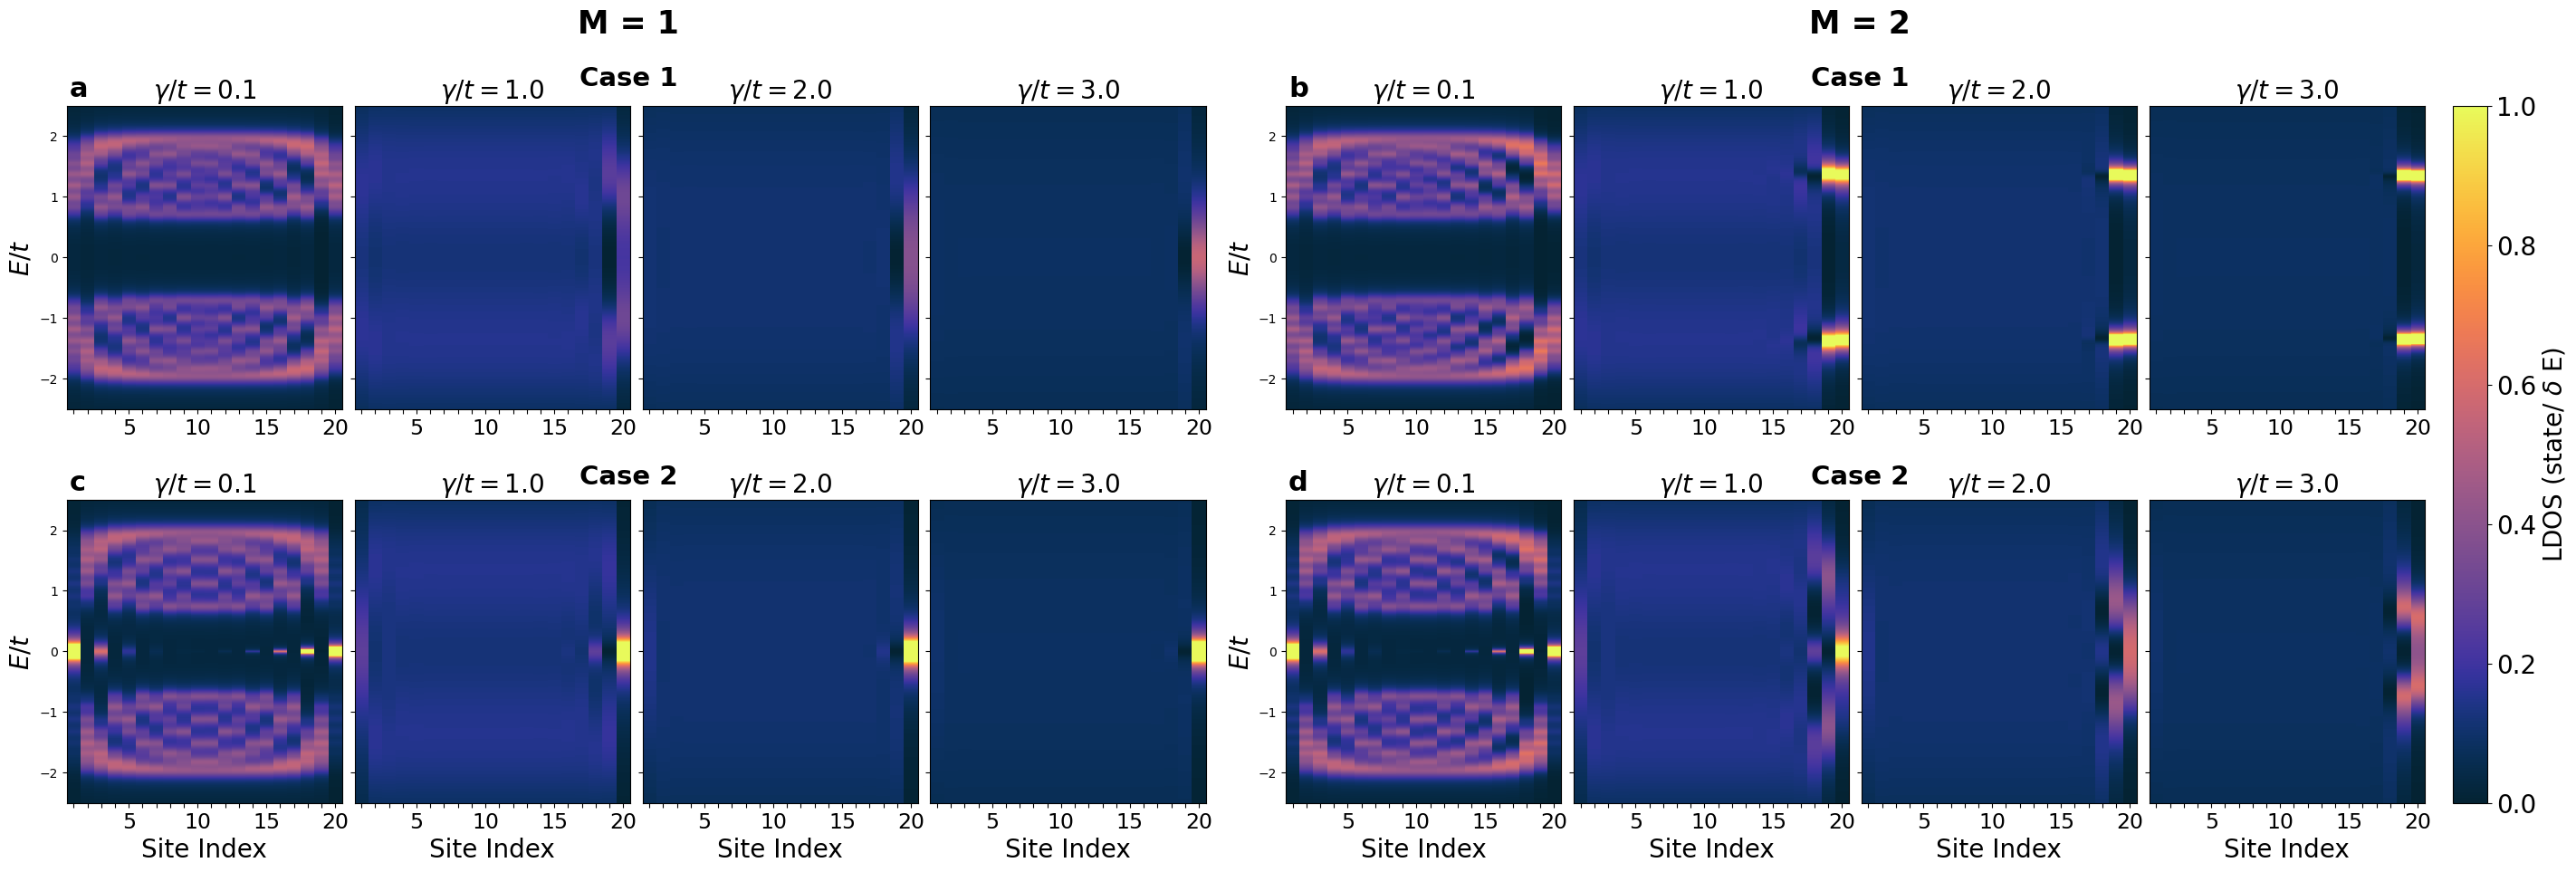

In [38]:
# 1) Compute a second batch of LDOS for M = 2
# change M below:
M = 2
ldos_M2_trivial = compute_ldos_for_params(t1_triv, t2_triv, gamma_values, N, energyGrid)
ldos_M2_nontrivial = compute_ldos_for_params(t1_nontriv, t2_nontriv, gamma_values, N, energyGrid)

# 2) Define the figure and GridSpec layout
fig = plt.figure(figsize=(40, 10))
gs = fig.add_gridspec(
    2, 9,
    width_ratios=[1, 1, 1, 1, 0.2, 1, 1, 1, 1],  # 0.2 is the gap between M=1 and M=2
    wspace=0.05,  # minimal horizontal spacing
    hspace=0.3   # vertical spacing between rows
)

# Create an array of axes
axes = np.empty((2, 8), dtype=object)

# Fill columns 0..3 with M=1 axes
for m in range(4):
    axes[0, m] = fig.add_subplot(gs[0, m])  # Top row
    axes[1, m] = fig.add_subplot(gs[1, m])  # Bottom row

# Skip column 4 (the gap) and fill columns 5..8 with M=2 axes
for m in range(4):
    axes[0, m + 4] = fig.add_subplot(gs[0, m + 5])  # Top row
    axes[1, m + 4] = fig.add_subplot(gs[1, m + 5])  # Bottom row

X_sites, Y_energy = np.meshgrid(np.arange(2 * N), energyGrid)

# Custom tick positions and labels
custom_ticks = np.arange(2 * N) + 1  # Ticks from 1 to 20
custom_labels = [str(x) if x in [5, 10, 15, 20] else "" for x in custom_ticks]

# Panel labels + positions
panel_labels = ['a', 'b', 'c', 'd']
label_positions = [(0, 0), (0, 4), (1, 0), (1, 4)]  # (row, col) for labeled panels

# 3) Plot M = 1 data on the left half (columns 0-3)
for m, gamma in enumerate(gamma_values):
    ## Top row: Trivial (panel a => col 0) ---
    LDOSperSite = ldos_trivial[m]
    ax = axes[0, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    if m == 0:  # Add y-axis label for panel "a"
        ax.set_ylabel('$E/t$', fontsize=20)
    ax.set_xticks(custom_ticks - 1)
    ax.set_xticklabels(custom_labels, fontsize=17)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=20)
    if (0, m) in label_positions:
        ax.text(0.01, 1.10, panel_labels[label_positions.index((0, m))],
                transform=ax.transAxes, fontsize=22, fontweight='bold',
                va='top', ha='left')

    # Modify y-ticks
    if m > 0:
        ax.set_yticklabels([])  # Only keep y-ticks, no labels

    ## Bottom row: Non-trivial (panel c => col 0) ---
    LDOSperSite = ldos_nontrivial[m]
    ax = axes[1, m]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    if m == 0:  # Add y-axis label for panel "c"
        ax.set_ylabel('$E/t$', fontsize=20)
    ax.set_xlabel('Site Index', fontsize=20)
    ax.set_xticks(custom_ticks - 1)
    ax.set_xticklabels(custom_labels, fontsize=17)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=20)
    if (1, m) in label_positions:
        ax.text(0.01, 1.10, panel_labels[label_positions.index((1, m))],
                transform=ax.transAxes, fontsize=22, fontweight='bold',
                va='top', ha='left')

    # Modify y-ticks
    if m > 0:
        ax.set_yticklabels([])  # Only keep y-ticks, no labels

# 4) Plot M = 2 data on the right half (columns 4-7)
for m, gamma in enumerate(gamma_values):
    # --- Top row (panel b => col 4) ---
    LDOSperSite = ldos_M2_trivial[m]
    ax = axes[0, m + 4]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    if m == 0:  # Add y-axis label for panel "b"
        ax.set_ylabel('$E/t$', fontsize=20)
    ax.set_xticks(custom_ticks - 1)
    ax.set_xticklabels(custom_labels, fontsize=17)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=20)
    if (0, m + 4) in label_positions:
        ax.text(0.01, 1.10, panel_labels[label_positions.index((0, m + 4))],
                transform=ax.transAxes, fontsize=22, fontweight='bold',
                va='top', ha='left')

    # Modify y-ticks
    if m > 0:
        ax.set_yticklabels([])  # Only keep y-ticks, no labels

    # --- Bottom row (panel d => col 4) ---
    LDOSperSite = ldos_M2_nontrivial[m]
    ax = axes[1, m + 4]
    pcm = ax.pcolormesh(X_sites, Y_energy, LDOSperSite.T,
                        cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax, rasterized=True)
    if m == 0:  # Add y-axis label for panel "d"
        ax.set_ylabel('$E/t$', fontsize=20)
    ax.set_xlabel('Site Index', fontsize=20)
    ax.set_xticks(custom_ticks - 1)
    ax.set_xticklabels(custom_labels, fontsize=17)
    ax.set_title(r'$\gamma / t = {:.1f}$'.format(gamma), fontsize=20)
    if (1, m + 4) in label_positions:
        ax.text(0.01, 1.10, panel_labels[label_positions.index((1, m + 4))],
                transform=ax.transAxes, fontsize=22, fontweight='bold',
                va='top', ha='left')

    # Modify y-ticks
    if m > 0:
        ax.set_yticklabels([])  # Only keep y-ticks, no labels

# 5) Add global titles + suptitle for M = 1 and M = 2
fig.text(0.28, 0.97, "M = 1", ha='center', va='center', fontsize=25, fontweight='bold')
fig.text(0.62, 0.97, "M = 2", ha='center', va='center', fontsize=25, fontweight='bold')

fig.text(0.28, 0.91, "Case 1", ha='center', va='center', fontsize=21, fontweight='bold')
fig.text(0.62, 0.91, "Case 1", ha='center', va='center', fontsize=21, fontweight='bold')

fig.text(0.28, 0.47, "Case 2", ha='center', va='center', fontsize=21, fontweight='bold')
fig.text(0.62, 0.47, "Case 2", ha='center', va='center', fontsize=21, fontweight='bold')

# 6) Single colorbar for all subplots
cbar = fig.colorbar(pcm, ax=axes.ravel().tolist(), label='LDOS (state/ $\delta$ E)', pad=0.01)
cbar.set_label('LDOS (state/ $\delta$ E)', fontsize=20)
cbar.ax.tick_params(labelsize=20)

# 7) Save and show
plt.savefig('fig6Combo4.pdf', format='pdf', bbox_inches='tight')
plt.show()
